<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

--- 
# Contents


---

### Contents:
Notebook 1
 - Part 1
    - Problem statement
    - Summary
 - Part 2
   - Importing libraries and loac CSV
   - spray.csv
   - weather.csv
   - train.csv
   - Feature engineering
   - Combine Train and weather data
- Part 3
   - Modeling preprocessing
   - Train model
   - Test data manipulation
   - RandomForest model
   - Adaboost model
   - XGboost model
   - Logistic regression model
- Part 4
   - Conclusions and Recommendations

--- 
# Part 1

Problem Statement and Introduction

---

## Problem Statement

To analyse weather, location, testing and spraying GIS data to build a statistical model for the **optimal prediction of the presence, time, location and species of West Nile Virus (WNV) in Chicago.**

Concurrently, The Chicago Municipality and Chicago Department of Public Health is interested in identifying the highest number of WNV cases possible (sensitivity) rather than avoid False Positives, (where WNV is predicted but there isn't a case). 

This is due to the high cost of an undetected WNV (due to health implications) as compared to the cost involved in spraying an area with presticide due to a false alarm.

Success is evaluated by ensuring that the model has the **highest Area Under the Curve score**, which signifies that the model is robust enough to allow flexible choice of thresholds. This can be verified on the Kaggle Website.

The Chicago Municipality and Chicago Department of Public Health can choose the model with the **highest sensitivity when WNV is pandemic** and subsequently, model with the **highest precision** when the number of incidences is lower.

## Summary

- West Nile Virus is most commmonly spread through infected mosquitos
- 20% of people who are infected, develop symptoms ranging from fever, to serious neurological illness and death.
- In 2002, first human cases of WNV	were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of	Public Health (CDPH) had established a comprehensive surveillance and control program.
- Every week, mosquitos in traps across the city are tested for the virus. The results of these tests infludence when and where the city will spray pesticides.
- Given weather, location, testing, and spraying data, Chicago Municipality and CDPH 

--- 
# Part 2
Data cleaning
---

## 2.1 Importing libraries and load CSV

In [1]:
! pip install xgboost

In [2]:
# import libraries

# maths
import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas.api.types import is_numeric_dtype

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder

from scipy.stats import ttest_ind

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import matthews_corrcoef, plot_confusion_matrix,accuracy_score,plot_roc_curve,auc, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
#regularizing gradient boosting
from xgboost import XGBClassifier, XGBRFClassifier 

from ipywidgets import IntSlider, interact

import warnings
warnings.filterwarnings('ignore')

In [3]:
# pd.set_option('display.max_columns', 4000)
# pd.set_option('display.max_rows', 4000)

In [4]:
#load CSV files
spray = pd.read_csv('../datasets/spray.csv')
weather= pd.read_csv('../datasets/weather.csv')
train= pd.read_csv('../datasets/train.csv')
test= pd.read_csv('../datasets/test.csv')

## 2.2 Spray.csv

Spray.csv is the City of Chicago schedule for spraying; to kill mosquitos

In [5]:
#make a definition to explore csv file
def explore(df):
    print(df.shape)
    print("")
    print(df.head())
    print("")
    print(df.dtypes)
    print("")
    print(df.isnull().sum())
    print("")
    print(df.describe())
    
explore(spray)

(14835, 4)

         Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

           Latitude     Longitude
count  14835.000000  14835.000000
mean      41.904828    -87.736690
std        0.104381      0.067292
min       41.713925    -88.096468
25%       41.785001    -87.794225
50%       41.940075    -87.727853
75%       41.980978    -87.694108
max       42.395983    -87.586727


Null values in time feature may be a problem

In [6]:
#checking the list of date that spraying occured
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Time'] = pd.to_timedelta(spray['Time'])
spray.groupby(['Date']).count()

,Time,Latitude,Longitude
Date,,,
2011-08-29,95,95,95
2011-09-07,1530,2114,2114
2013-07-17,2202,2202,2202
2013-07-25,1607,1607,1607
2013-08-08,1195,1195,1195
2013-08-15,2668,2668,2668
2013-08-16,141,141,141
2013-08-22,1587,1587,1587
2013-08-29,2302,2302,2302


In [7]:
spray2 = spray
spray2['Year'] = spray2['Date'].dt.year
spray2['Month'] = spray2['Date'].dt.month
spray2['Day'] = spray2['Date'].dt.day

In [8]:
#checking which are the dates that time is null
null = lambda spray: spray[spray.isnull().any(axis=1)]
null(spray)

,Date,Time,Latitude,Longitude,Year,Month,Day
1030,2011-09-07,NaT,41.987092,-87.794286,2011,9,7
1031,2011-09-07,NaT,41.987620,-87.794382,2011,9,7
1032,2011-09-07,NaT,41.988004,-87.794574,2011,9,7
1033,2011-09-07,NaT,41.988292,-87.795486,2011,9,7
1034,2011-09-07,NaT,41.988100,-87.796014,2011,9,7
...,...,...,...,...,...,...,...
1609,2011-09-07,NaT,41.995876,-87.811615,2011,9,7
1610,2011-09-07,NaT,41.995972,-87.810271,2011,9,7
1611,2011-09-07,NaT,41.995684,-87.810319,2011,9,7
1612,2011-09-07,NaT,41.994724,-87.810415,2011,9,7


Spray have got 14835 data rows with 4 columns (Date, Time, Latitude, Longitude)

null values:
1. 584 null values 
2. Time column only
3. All in 2011-09-07
4. Not all 2011-09-07 time are null values (584/1530 are nulls)
5. Changed Time to timedelta respectively
    
    
2 rounds of sprays in 2011, Aug and Sept 
8 rounds of sprays in 2013, 2 in July, 5 in Aug, 1 in Sept
Might be linked to climate and mosquitoes breeding season, increased in recorded viral infections, etc

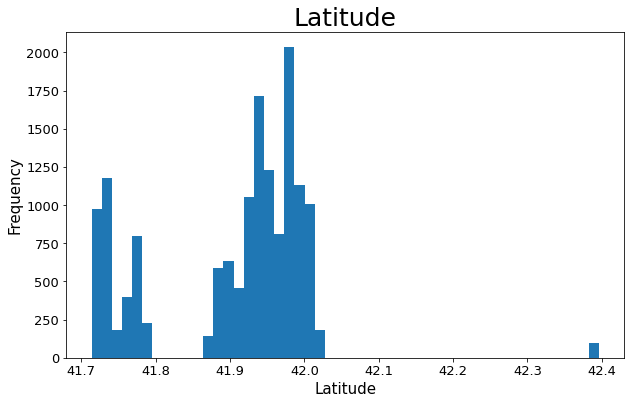

In [9]:
#EDA for latitude
plt.figure(figsize=(10,6))

plt.hist(spray['Latitude'],50);

plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
plt.xlabel("Latitude", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Latitude", fontsize=25);

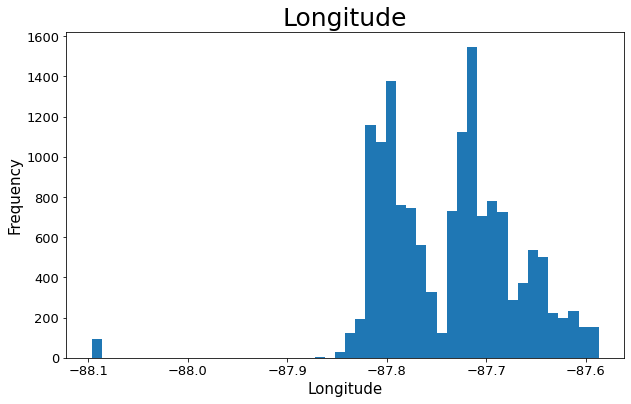

In [10]:
#EDA for longitude
plt.figure(figsize=(10,6))

plt.hist(spray['Longitude'],50);

plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Longitude", fontsize=25);

In [11]:
#Locations at -88.1/42.4 is outside our scope, We will remove them
del_row = spray[spray['Latitude']>42.3].index
spray.drop(del_row, axis=0, inplace=True)
spray.shape

(14740, 7)

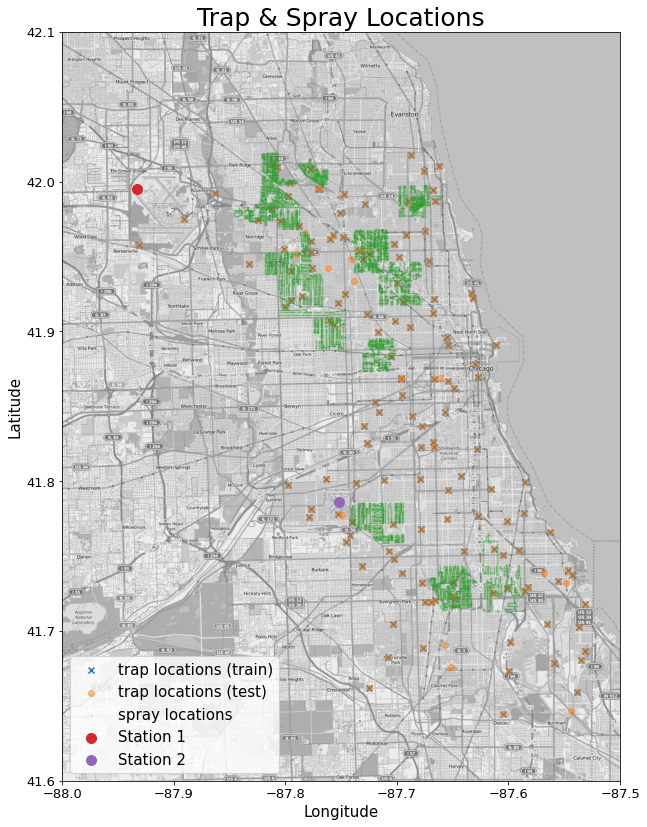

In [12]:
mapdata = np.loadtxt("../datasets/mapdata_copyright_openstreetmap_contributors.txt")
traps_train = pd.read_csv('../datasets/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
traps_test = pd.read_csv('../datasets/test.csv')[['Date', 'Trap','Longitude', 'Latitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_train_traps = traps_train[['Longitude', 'Latitude']].drop_duplicates().values
locations_test_traps = traps_test[['Longitude', 'Latitude']].drop_duplicates().values
spray_locations = spray[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(locations_train_traps[:,0], locations_train_traps[:,1], marker='x')
plt.scatter(locations_test_traps[:,0], locations_test_traps[:,1], marker='o', alpha=0.5)
plt.scatter(spray_locations[:,0], spray_locations[:,1], s=1, alpha=0.2)
plt.scatter(-87.933, 41.995, marker='o', s=100)
plt.scatter(-87.752, 41.786, marker='o', s=100)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Latitude", fontsize=15)
plt.title("Trap & Spray Locations", fontsize=25)
plt.legend(["trap locations (train)", "trap locations (test)", 
            "spray locations", 'Station 1', 'Station 2'], fontsize=15);

In [13]:
#save cleaned spray dataset to a new dataset
spray_cleaned=spray
spray_cleaned.to_csv("../datasets/spray_cleaned.csv", index=False)

## 2.3 Weather.csv

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [14]:
explore(weather)

(2944, 22)

   Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1       

In [15]:
#expand the Date column to Year,Month,Day to check on the period of data and see if there are any missing days/months
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Year'] = weather['Date'].dt.year
weather['Month'] = weather['Date'].dt.month
weather['Day'] = weather['Date'].dt.day

In [16]:
print (weather['Day'].shape)
print (weather['Month'].shape)
print (weather['Year'].shape)

(2944,)
(2944,)
(2944,)


In [17]:
#confirmed no missing, weird dates
weather.drop(columns=['Day', 'Month', 'Year'], inplace=True)

In [18]:
#Replacing all - and empty string to np.nan
#M is found in Tavg, Depart, Heat, cool, depth and water1
weather = weather.replace('-',np.nan)
weather = weather.replace(' ',np.nan)

In [19]:
#'depart' is departure from normal
# It does not give much information, and a lot of values are missing
# Therefore, this column will be dropped
print('Amount of rows with missing data in Depart column:', weather[weather['Depart'] == 'M'].shape[0])
weather.drop(columns='Depart', inplace=True)

Amount of rows with missing data in Depart column: 1472


In [20]:
# DewPoint and WetBulb features are a measure of humidity, therefore should keep
# Heat, Cool is info. on the hotness/coolness on that day, which is given by the Temperature measurements already
# Sunrise, Sunset, SnowFall is also kind of related to the temperature 
weather.drop(columns=['Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall'], inplace=True)

In [21]:
# As high number of missing values in Depth and Water1 columns, drop these columns
print('Number of missing values in Depth column:', weather[weather['Depth'] == 'M'].shape[0])
print('Number of missing values in Water1 column:', weather[weather['Water1'] == 'M'].shape[0])
weather.drop(columns=['Depth', 'Water1'], inplace=True)

Number of missing values in Depth column: 1472
Number of missing values in Water1 column: 2944


In [22]:
# There are some missing values in Tavg
weather[weather['Tavg'] == 'M'].shape
# Since there are only 11 missing values for Tavg out of 2944 entries, we will drop the values
weather = weather[weather['Tavg'] != 'M']

In [23]:
# Drop StnPressure, SeaLevel, ResultSpeed, ResultDir and AvgSpeed
# These are generic conditions which do not really relate to mosquito population
weather.drop(columns=['StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'], inplace=True)

In [24]:
#PrecipTotal cleaning 
#'T' has whitespace in front, must use .strip() to clean it
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.strip())

# Convert 'T' entries to 0, and convert dtype to float
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('T', '0.001'))
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('M', '0'))
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [25]:
#changing some columns to float, putting it this way to allow easy alterations in the future
columns = ['Tavg']

for i in columns:
    weather[i] = weather[i].astype(str).astype(float)

In [26]:
explore(weather)

(2933, 9)

   Station       Date  Tmax  Tmin  Tavg  DewPoint WetBulb CodeSum  PrecipTotal
0        1 2007-05-01    83    50  67.0        51      56     NaN          0.0
1        2 2007-05-01    84    52  68.0        51      57     NaN          0.0
2        1 2007-05-02    59    42  51.0        42      47      BR          0.0
3        2 2007-05-02    60    43  52.0        42      47   BR HZ          0.0
4        1 2007-05-03    66    46  56.0        40      48     NaN          0.0

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
DewPoint                int64
WetBulb                object
CodeSum                object
PrecipTotal           float64
dtype: object

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
DewPoint          0
WetBulb           0
CodeSum        1603
PrecipTotal       0
dtype: int64

           Station         Tmax    

**Note**

We want to remove all columns that are not related. Specifically, we  our analysis on the variables concerning temperature and humidity. The reason why heating degree days and cooling degree days are dropped becayse there are other variables that capture temperature will be good enough.

|Features|Dropped/Keep|
|----|----|
|Station|Keep|
|Date|Keep|
|Tmax|Feature engineering later|
|Tmin|Feature engineering later|
|Tavg|Feature engineering later|
|Depart|Droped|
|DewPoint|Feature engineering later|
|WetBulb|Keep|
|Heat|Droped|
|Cool|Droped|
|Sunrise|Droped|
|Sunset|Droped|
|CodeSum|Dropped|
|Depth|Droped|
|Water1|Droped|
|SnowFall|Droped|
|PrecipTotal|EDA|
|StnPressure|Droped|
|SeaLevel|Droped|
|ResultSpeed|Droped|
|ResultDir|Droped|
|AvgSpeed|Droped|

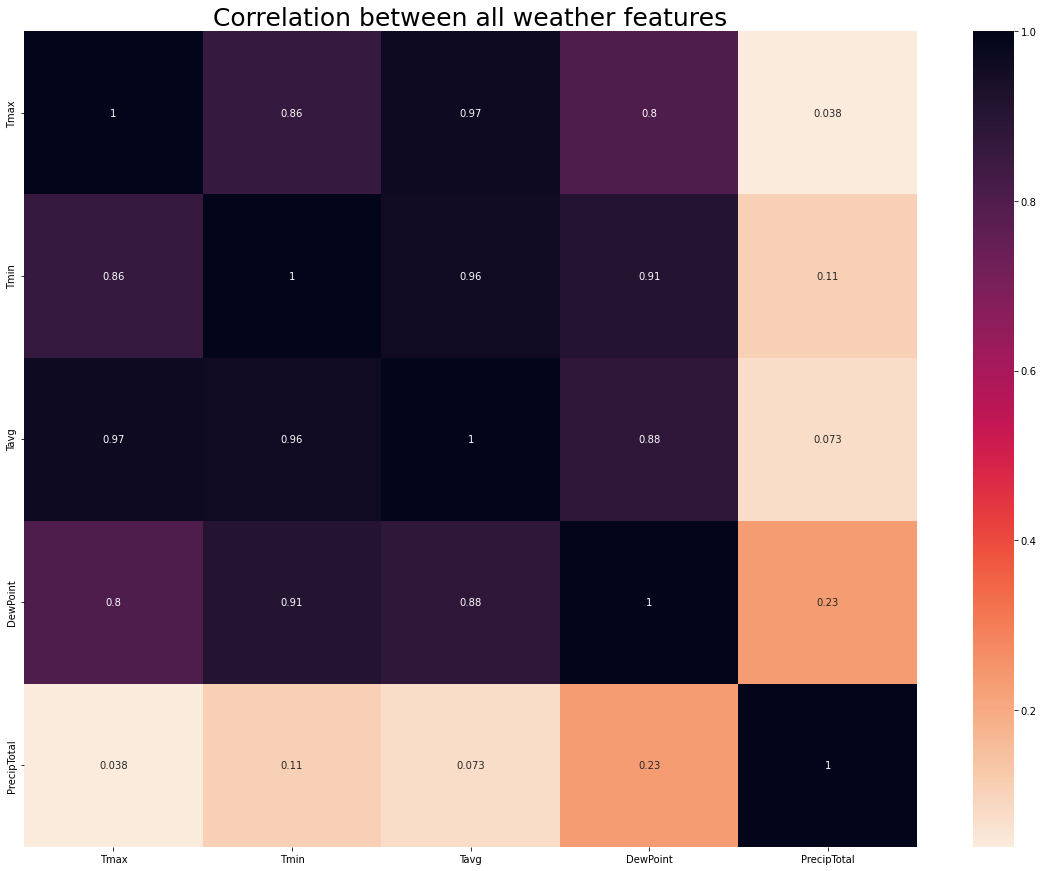

In [27]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
#sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(weather.drop(columns='Station').corr(), annot=True, cmap="rocket_r" ,ax = ax)
plt.title("Correlation between all weather features", fontsize=25);
plt.show()

In [28]:
weather_cleaned=weather
weather_cleaned.to_csv("../datasets/weather_cleaned.csv", index=False)

In [29]:
#function for plots

def plot_weather_trend_year(col_lst = weather.columns[1:]):
    for col in col_lst:
        ax = weather.groupby(weather['Date'].dt.year).mean()[col].sort_index().plot(kind='bar')
        ax.set_ylabel(f'{col}')
        ax.set_xlabel('Year')
        plt.show()

In [30]:
#extracting year, month , week and day
weather['Year'] = weather.Date.apply(lambda x:x.year)
weather['Month'] = weather.Date.apply(lambda x:x.month)
weather['Week'] = weather.Date.apply(lambda x:x.week)
weather['Day'] = weather.Date.apply(lambda x:x.day)

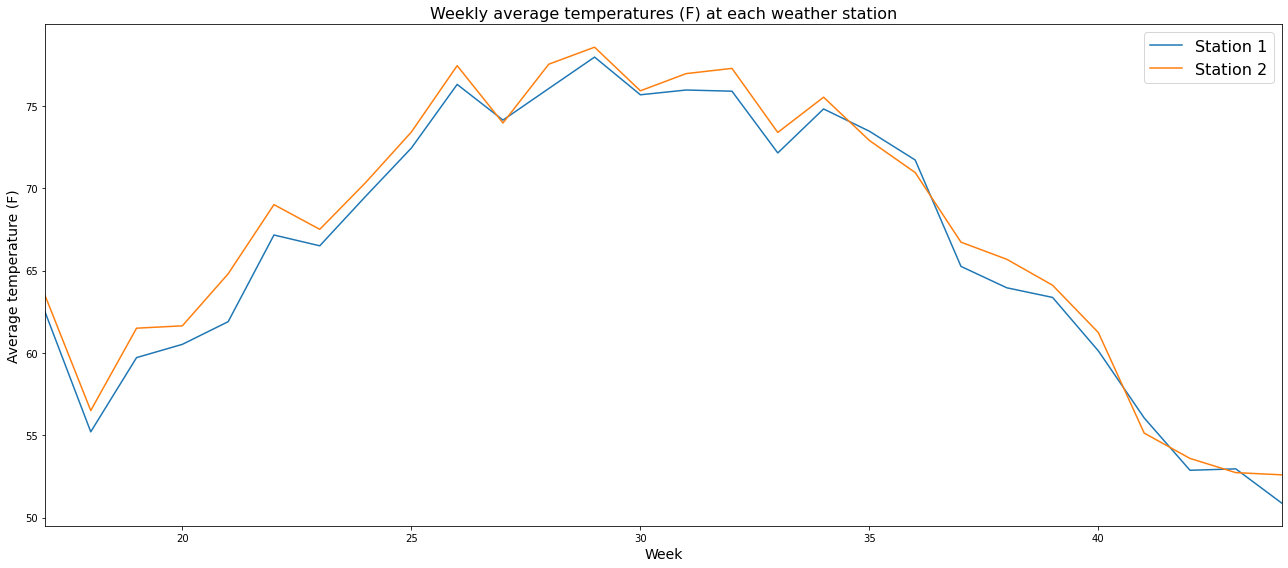

In [31]:
#7 Day Rolling Average Precipitation 
#station1
station1_df = weather[weather.Station == 1]
station1_7D_prep_avg = pd.DataFrame(weather[weather.Station == 1].PrecipTotal.rolling(7).mean())
station1_7D_prep_avg.rename(columns={'PrecipTotal':'precip_7D_avg'},inplace=True) 
station1_combined = pd.merge(station1_df,station1_7D_prep_avg,left_index=True,right_index=True)
station1_combined.dropna(inplace=True)
# station1_combined.fillna(value=0,inplace=True)
#station2
station2_df = weather[weather.Station == 2]
station2_7D_prep_avg = pd.DataFrame(weather[weather.Station == 2].PrecipTotal.rolling(7).mean())
station2_7D_prep_avg.rename(columns={'PrecipTotal':'precip_7D_avg'},inplace=True) 
station2_combined = pd.merge(station2_df,station2_7D_prep_avg,left_index=True,right_index=True)
station2_combined.dropna(inplace=True)
# station2_combined.fillna(value=0,inplace=True)

weather = pd.concat([station1_combined,station2_combined]).sort_index()

# plot weekly temperature by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Week',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'Week',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 16)
plt.title('Weekly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Week',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather.Week.min(), weather.Week.max())
plt.tight_layout()

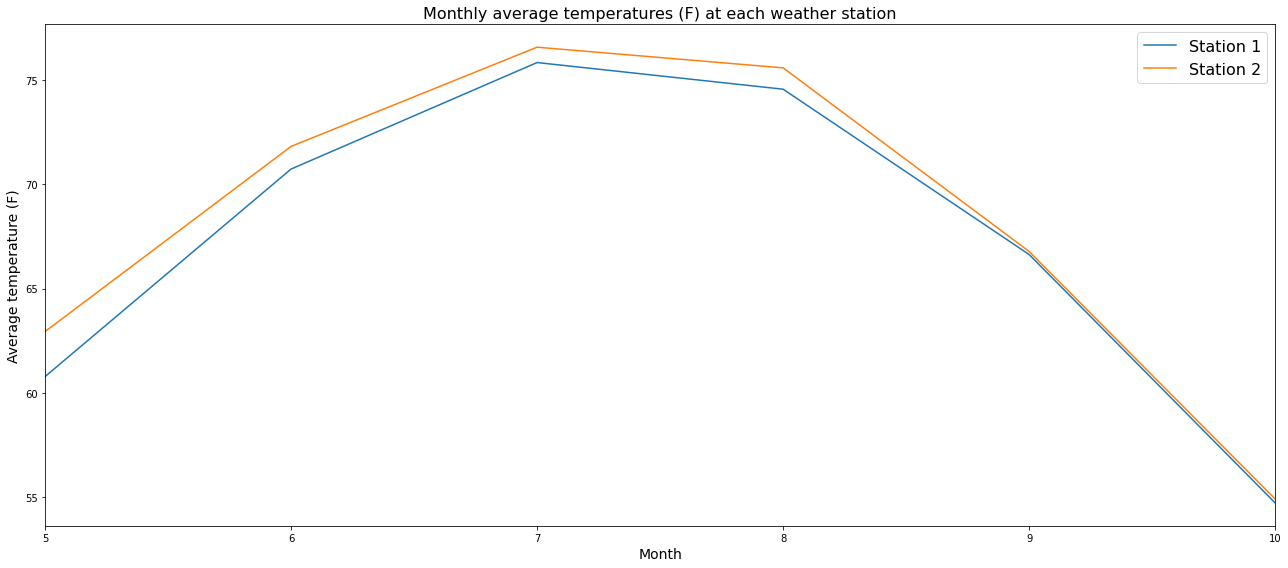

In [32]:
# plot Monthly temperature by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Month',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'Month',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 16)
plt.title('Monthly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather.Month.min(), weather.Month.max())
plt.tight_layout()

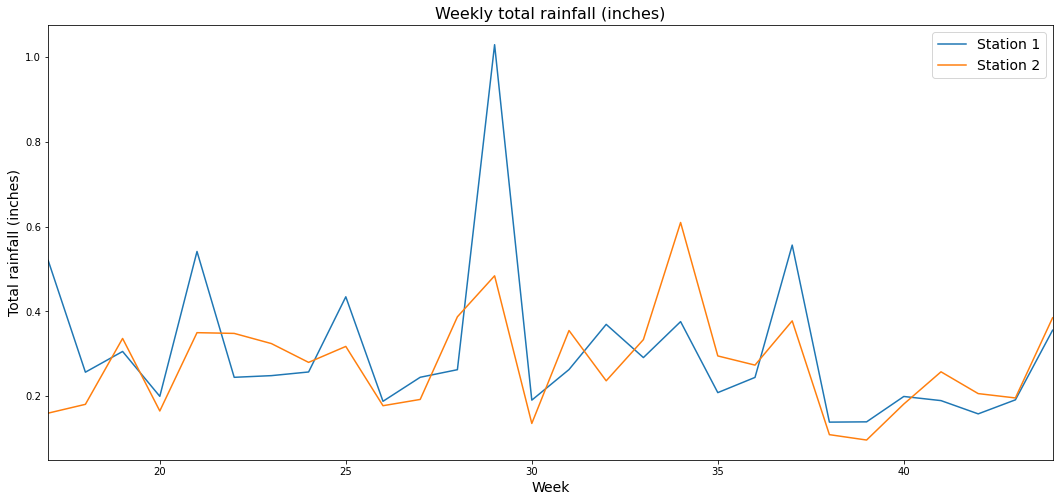

In [33]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Week',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'Week',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly total rainfall (inches)', fontsize=16)
plt.xlabel('Week',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather.Week.min(), weather.Week.max());

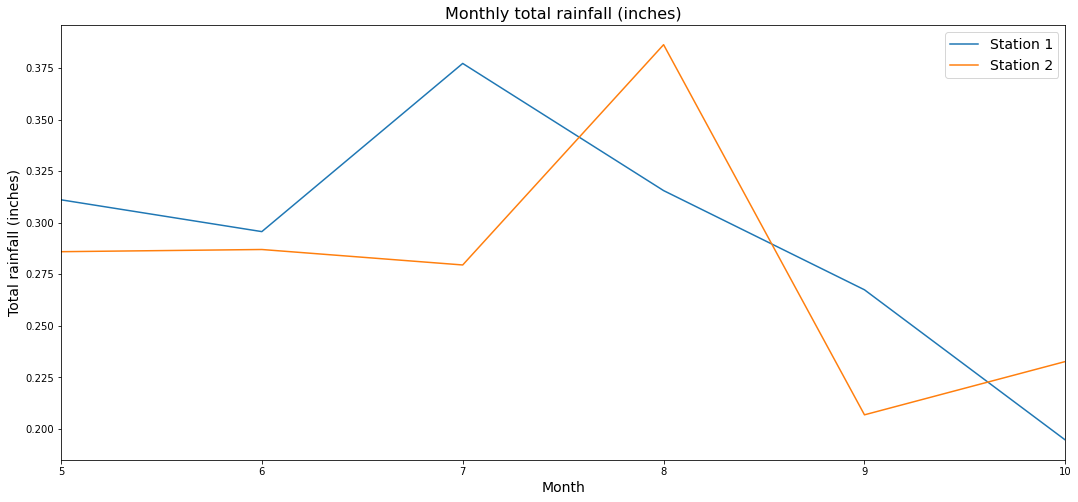

In [34]:
# plot Month rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Month',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'Month',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Monthly total rainfall (inches)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather.Month.min(), weather.Month.max());

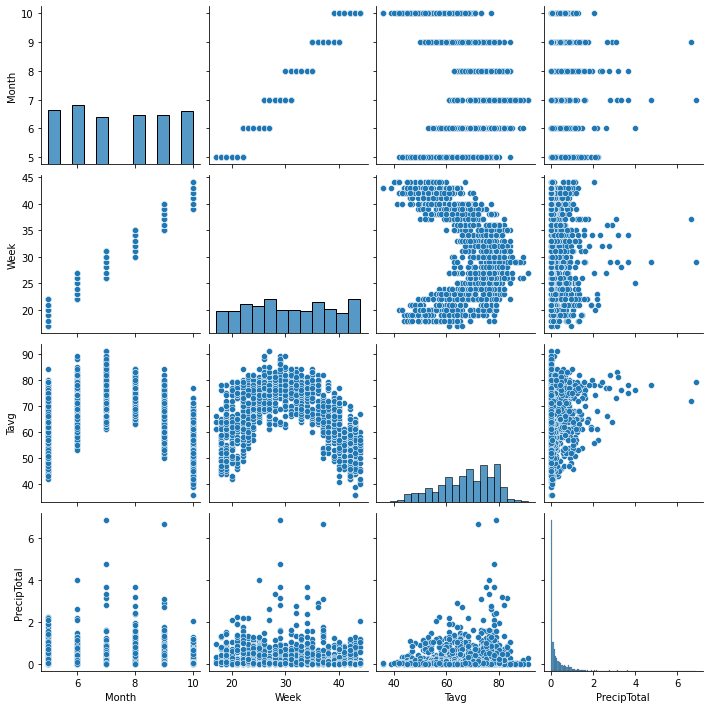

In [35]:
# A pairplot showing the scatter plots of temperature and precipitation against the time variables month and week
sns.pairplot(weather[['Month','Week','Tavg', 'PrecipTotal']]);

## 2.4 Train.csv

In [36]:
explore(train)

(10506, 12)

         Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991       

In [37]:
#expand the Date column to Year,Month,Day to check on the period of data and see if there are any missing days/months
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

print (train['Day'].shape)
print (train['Month'].shape)
print (train['Year'].shape)

(10506,)
(10506,)
(10506,)


In [38]:
#removed 813 duplicated values, result in 9693 values/rows
print(train.duplicated().sum())
train.drop_duplicates(inplace = True)
print(train.shape)

813
(9693, 15)


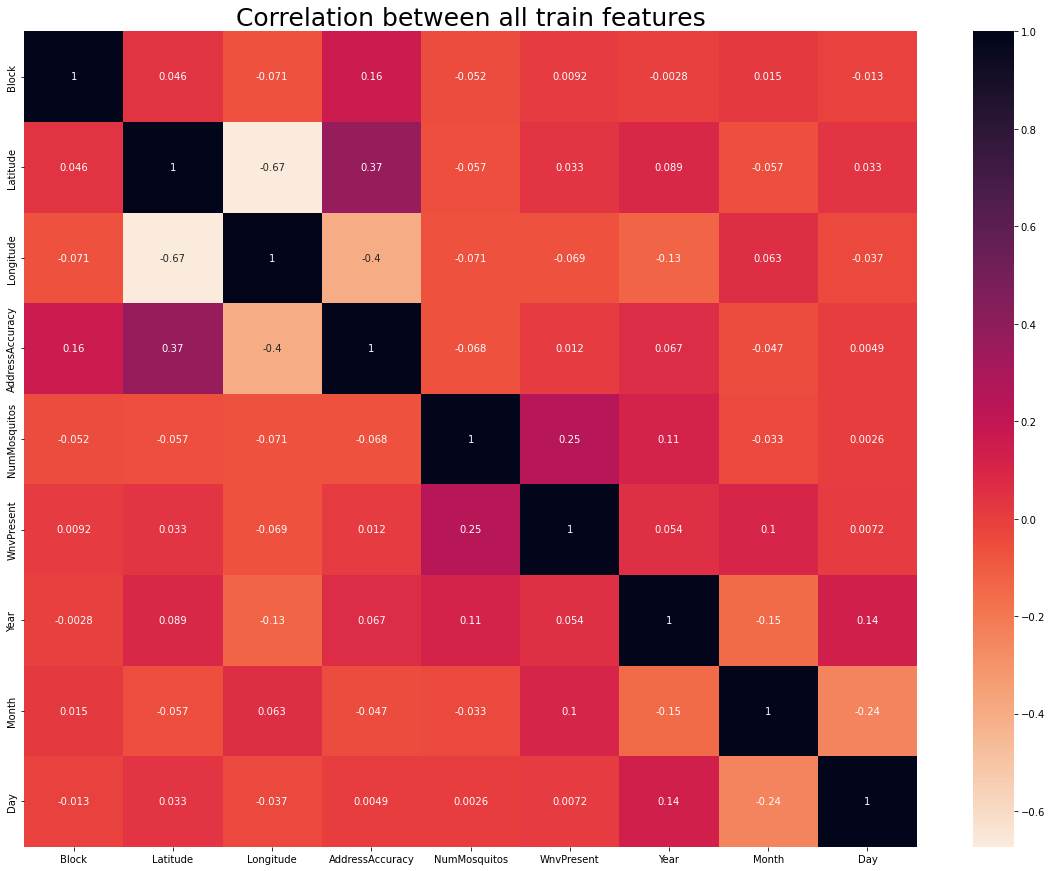

In [39]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
#sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(train.corr(), annot=True, cmap="rocket_r" ,ax = ax)
plt.title("Correlation between all train features", fontsize=25);
plt.show()

In [40]:
#convert date type
train['Date'] = pd.to_datetime(train['Date'])

In [41]:
#dropping unnecessary address columns from train data since 
#we are given information on the lat. and long. of each row 
train.drop(columns=['Address', 'Block', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)
train.shape

(9693, 11)

In [42]:
#converting categorical variables to dummies > train2 
train2=pd.get_dummies(train,columns=['Species', 'Trap'])

# train3 = train with , date seperated for EDA

train3 = train
train3['Year'] = train3['Date'].dt.year
train3['Month'] = train3['Date'].dt.month
train3['Day'] = train3['Date'].dt.day

In [43]:
train['WnvPresent'].value_counts(normalize = True)

0    0.948107
1    0.051893
Name: WnvPresent, dtype: float64

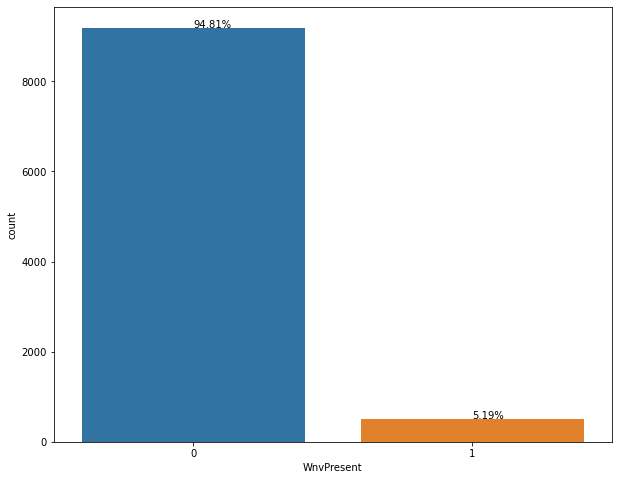

In [44]:
fig,  ax = plt.subplots(1,1, figsize = (10, 8))
sns.countplot(x = 'WnvPresent', data = train, ax = ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}{}'.format(height/len(train)*100,'%'))
plt.show()

In [45]:
train.loc[train['WnvPresent'] == 1, 'Species'].value_counts()

CULEX PIPIENS/RESTUANS    246
CULEX PIPIENS             208
CULEX RESTUANS             49
Name: Species, dtype: int64

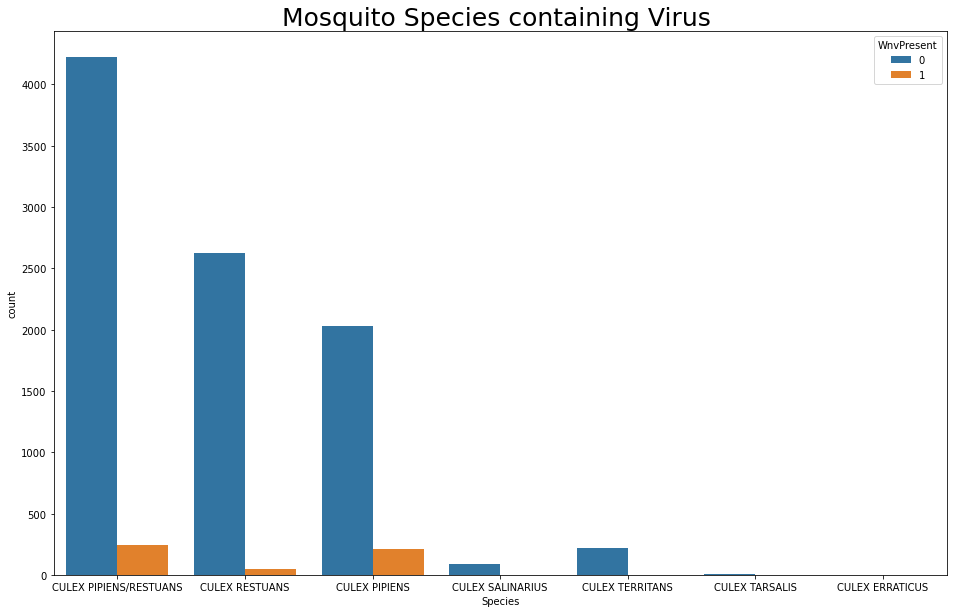

In [46]:
plt.subplots(figsize=(16,10))
ax2=sns.countplot('Species',data=train,hue='WnvPresent')
plt.title("Mosquito Species containing Virus ", fontsize=25);

<AxesSubplot:xlabel='Species'>

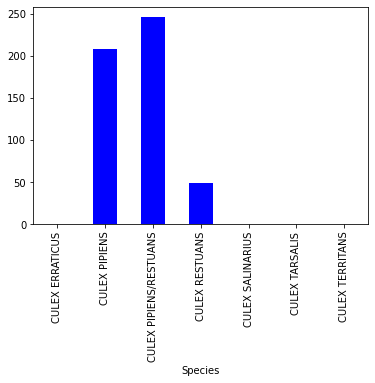

In [47]:
#only these 3 species are vectors
train.groupby('Species').WnvPresent.sum().plot(kind='bar',color='blue')

**Note**  
We can see that there are a higher probability that the Culex Pipiens/Restuans mosquitos would have the virus. According to the data we have, only these 3 species are vectors. No other species are found to carry the virus according to data collected

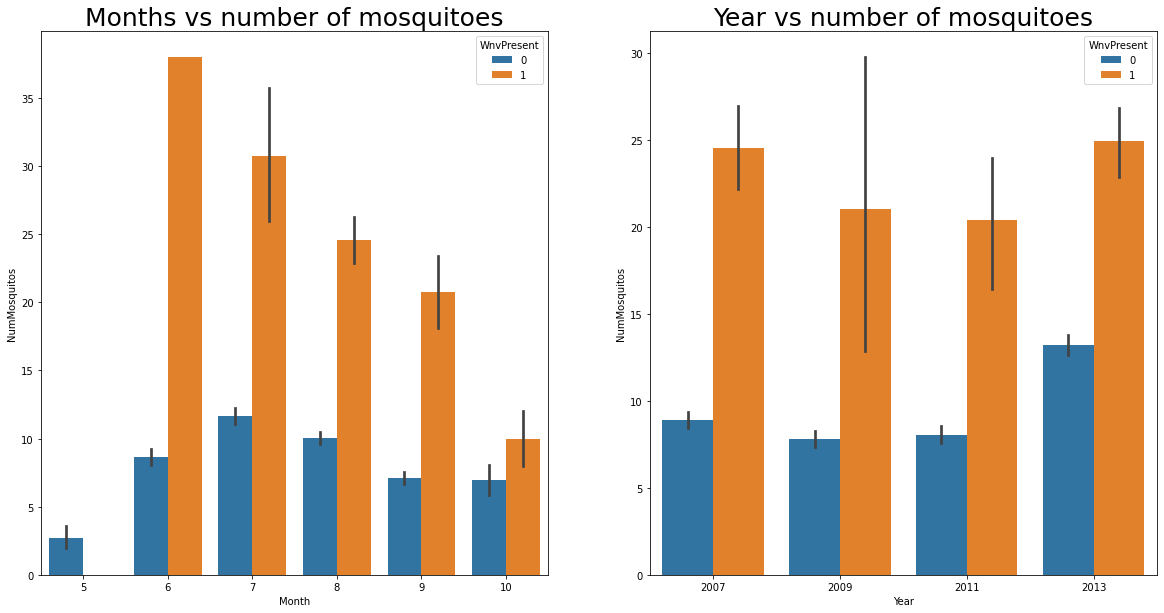

In [48]:
plt.subplots(figsize=(20,10))
plt.subplot(1,2,1),sns.barplot('Month','NumMosquitos',data=train3,hue='WnvPresent')  
plt.title("Months vs number of mosquitoes", fontsize=25);
ax2=plt.subplot(1,2,2),sns.barplot('Year','NumMosquitos',data=train3,hue='WnvPresent')
plt.title("Year vs number of mosquitoes", fontsize=25);

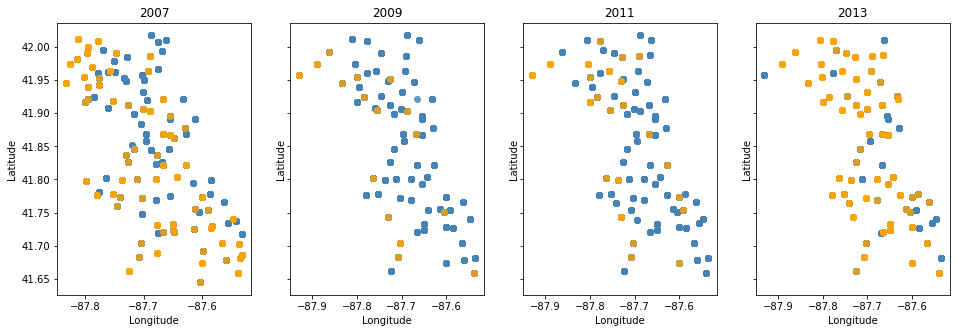

In [49]:
# visualising spread of virus across 2007 to 2013
def wnv_year():
    df = train3
    years = [2007,2009,2011,2013]
    fig,ax = plt.subplots(nrows=1,ncols=len(years), sharey=True)
    fig.set_size_inches(16, 5)
    for i, year in enumerate(years):
        Wnv_0= df[(df['Year']==years[i])&(df['WnvPresent']==0)]
        Wnvn_1= df[(df['Year']==years[i])&(df['WnvPresent']==1)]
        ax[i].set_title(year)
        sns.regplot('Longitude','Latitude',data=Wnv_0,ax=ax[i],color='steelblue', fit_reg=False)
        sns.regplot('Longitude','Latitude',data=Wnvn_1,ax=ax[i],color='orange', fit_reg=False)
        
wnv_year()

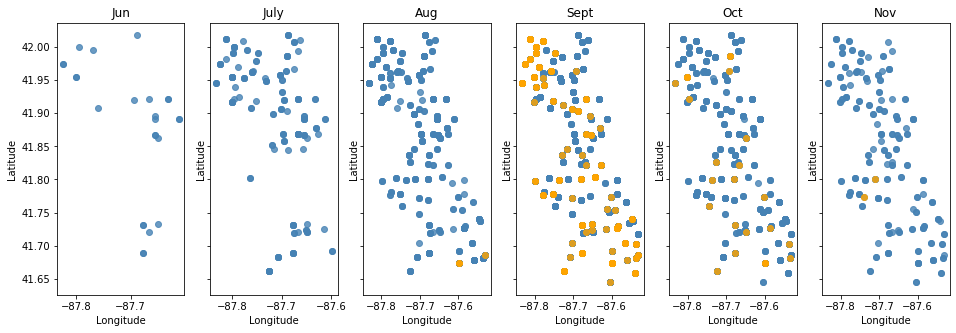

In [50]:
def wnv_year_month(wnv_year):
    df = train
    months = ['Jun','July', 'Aug','Sept','Oct', 'Nov']
    fig,ax = plt.subplots(nrows=1,ncols=len(months), sharey=True)
    fig.set_size_inches(16, 5)
    for i, month in enumerate(months):
        wnv_0= df[(df['Year']==wnv_year)&(df['WnvPresent']==0)&(df['Month']==i+5)]
        wnvn_1= df[(df['Year']==wnv_year)&(df['WnvPresent']==1)&(df['Month']==i+5)]
        ax[i].set_title(month)
        sns.regplot('Longitude','Latitude',data=wnv_0,ax=ax[i],color='steelblue', fit_reg=False)
        sns.regplot('Longitude','Latitude',data=wnvn_1,ax=ax[i],color='orange',fit_reg=False)
        
#visualising spread of virus across months in 2007
wnv_year_month(wnv_year = 2007)

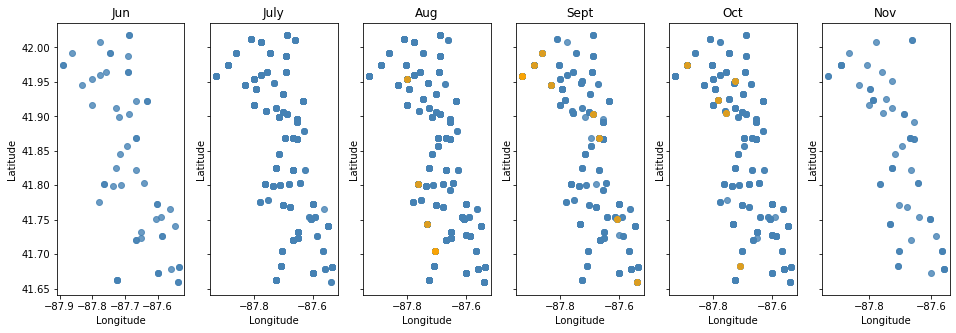

In [51]:
#visualising spread of virus across months in 2009
wnv_year_month(wnv_year = 2009)

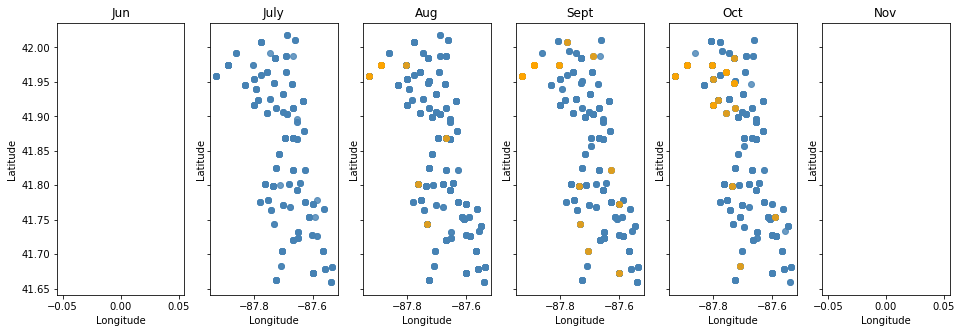

In [52]:
#visualising spread of virus across months in 2011
wnv_year_month(wnv_year = 2011)

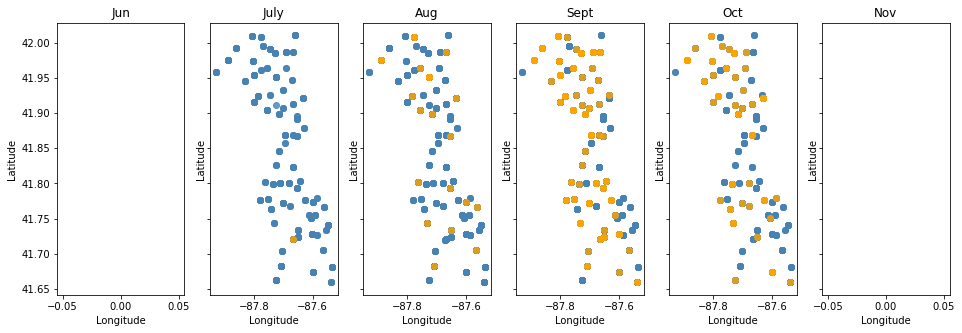

In [53]:
#visualising spread of virus across months in 2013
wnv_year_month(wnv_year = 2013)

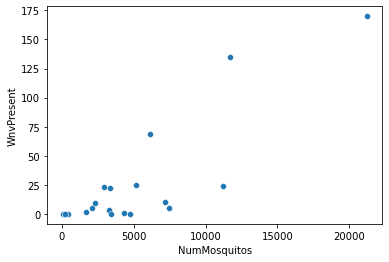

In [54]:
#more mosqutoes means more positive wnv
sns.scatterplot(x=train.groupby(['Year', 'Month']).NumMosquitos.sum(),
                y= train.groupby(['Year', 'Month']).WnvPresent.sum(),
               data=train);

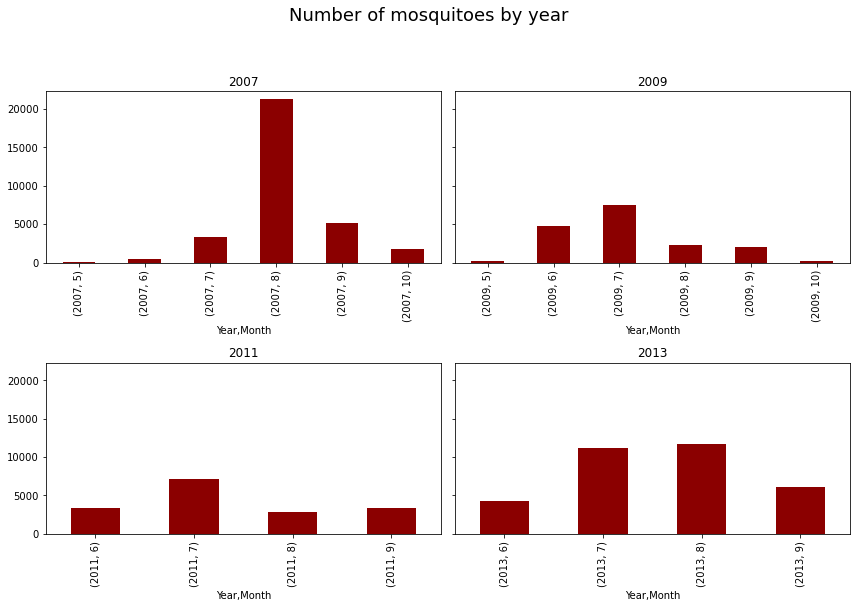

In [55]:
train_year = list(train['Year'].unique())
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Number of mosquitoes by year', fontsize=18, y=1.05)
for i, y in enumerate(train_year):
    train[train['Year']==y].groupby(['Year', 'Month']).NumMosquitos.sum().plot(kind='bar', ax=ax[i],color='darkred')
    ax[i].set_title(y)
plt.tight_layout()

**Note**  
More cases in July and Aug- Higher temperatures in summer could lead to more mosquitoes

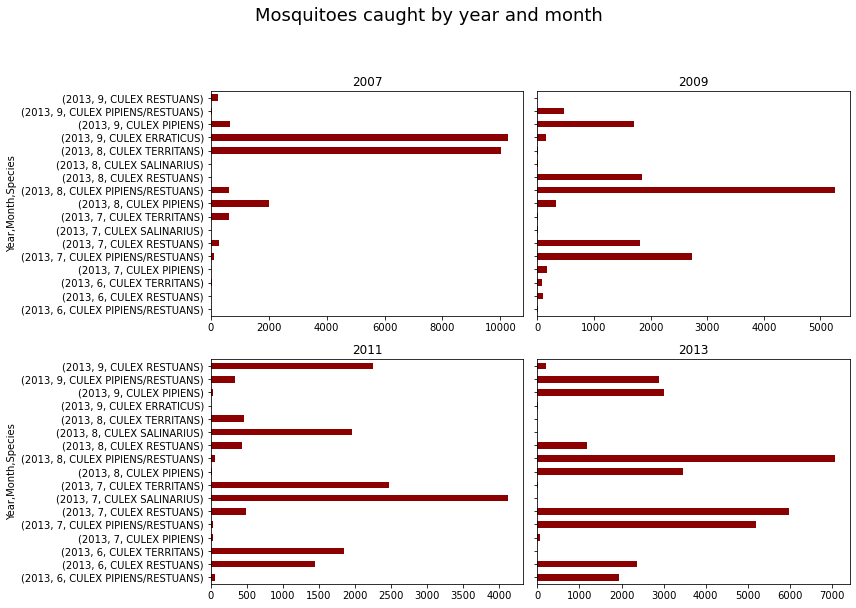

In [56]:
#number of mosquitoes by year and month
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Mosquitoes caught by year and month', fontsize=18, y=1.05)
for i, y in enumerate(train_year):
    train[train['Year']==y].groupby(['Year','Month','Species']).NumMosquitos.sum().plot(kind='barh', ax=ax[i],color='darkred')
    ax[i].set_title(y)
plt.tight_layout()

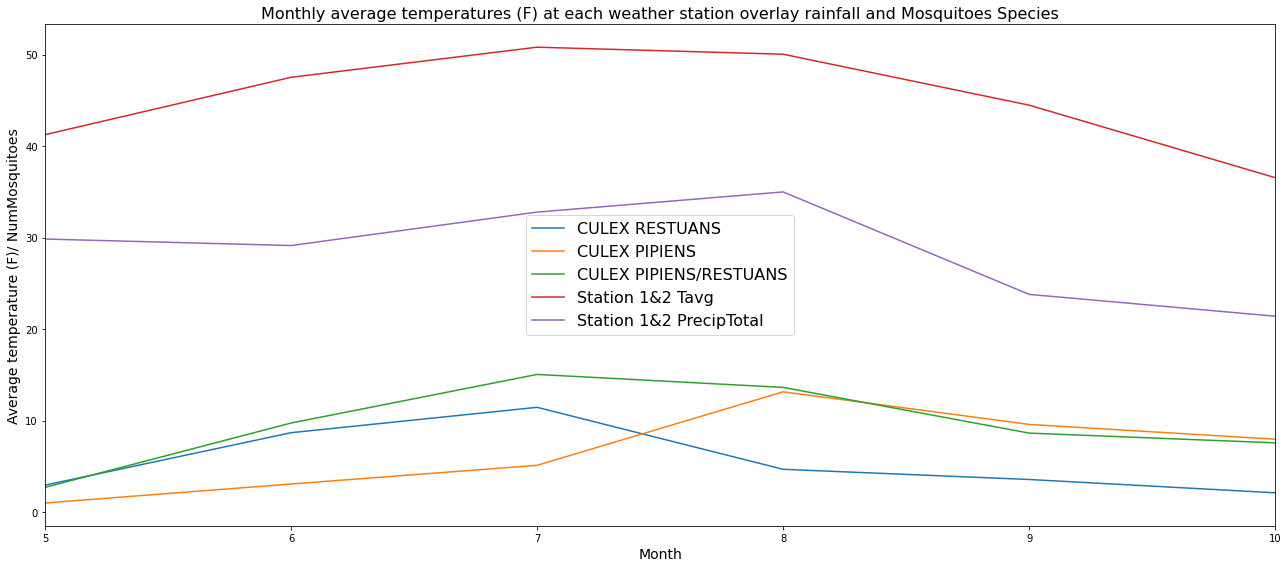

In [57]:
#overlay average temperature, Rainfall and top 3 mosquitoes vectors lineplot to see relationship between each other
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Month',y = 'NumMosquitos', data = train[train.Species== 'CULEX RESTUANS'], ci = None, label = "CULEX RESTUANS")
sns.lineplot(x = 'Month',y = 'NumMosquitos', data = train[train.Species== 'CULEX PIPIENS'], ci = None, label = "CULEX PIPIENS")
sns.lineplot(x = 'Month',y = 'NumMosquitos', data = train[train.Species== 'CULEX PIPIENS/RESTUANS'], ci = None, label = "CULEX PIPIENS/RESTUANS")
weather3=weather
#scale preciptotal and Tavg by a variable to see PrecipTotal patterns against other patterns better
weather3['PrecipTotal'] = weather3['PrecipTotal'] *100
weather3['Tavg'] = weather3['Tavg']/1.5

sns.lineplot(x = 'Month',y = 'Tavg', data = weather3, ci = None, label = "Station 1&2 Tavg")
sns.lineplot(x = 'Month',y = 'PrecipTotal',data = weather3,ci = None,label = "Station 1&2 PrecipTotal")
plt.legend(fontsize = 16)
plt.title('Monthly average temperatures (F) at each weather station overlay rainfall and Mosquitoes Species', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Average temperature (F)/ NumMosquitoes',fontsize=14)
plt.xlim(weather.Month.min(), weather.Month.max())
plt.tight_layout()

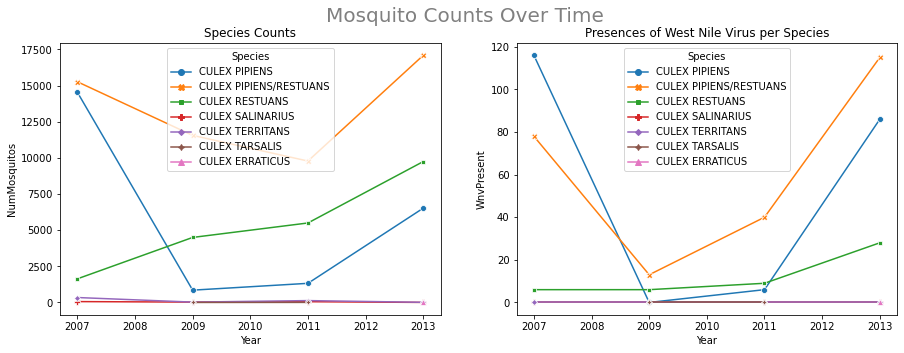

In [58]:
mosq_by_year = train[['Year','Species','NumMosquitos','WnvPresent']].groupby(['Year','Species']).agg('sum')
mosq_by_year.reset_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
fig.suptitle('Mosquito Counts Over Time', ha='center',color = 'grey',fontsize=20,va='top',) 

sns.lineplot(ax=ax1,data=mosq_by_year,x='Year',y='NumMosquitos',hue='Species', style='Species', markers=True,dashes=False)
ax1.set(title="Species Counts")

sns.lineplot(ax=ax2,data=mosq_by_year,x='Year',y='WnvPresent',hue='Species', style='Species', markers=True,dashes=False)
ax2.set(title="Presences of West Nile Virus per Species");

**Note**
There is a general increase in all 3 mosquitos vectors for the virus after 2009 

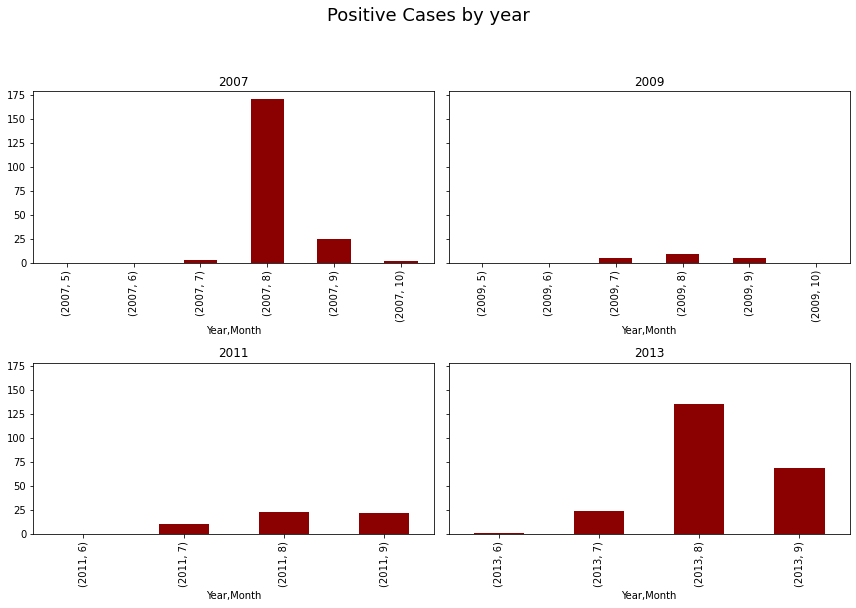

In [59]:
#positive WNV by year and month
#similarly, more positive cases during summer period
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Positive Cases by year', fontsize=18, y=1.05)
for i, y in enumerate(train_year):
    train[train['Year']==y].groupby(['Year','Month']).WnvPresent.sum().plot(kind='bar', ax=ax[i],color='darkred')
    ax[i].set_title(y)
plt.tight_layout()

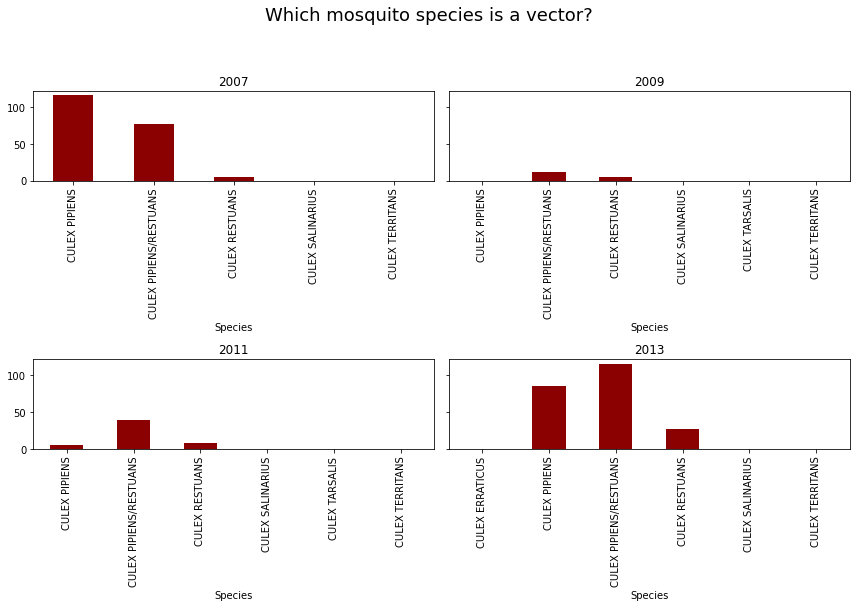

In [60]:
#positive WNV by by species
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Which mosquito species is a vector?', fontsize=18, y=1.05)
for i, y in enumerate(train_year):
    train[train['Year']==y].groupby(['Species']).WnvPresent.sum().plot(kind='bar', ax=ax[i],color='darkred')
    ax[i].set_title(y)
plt.tight_layout()

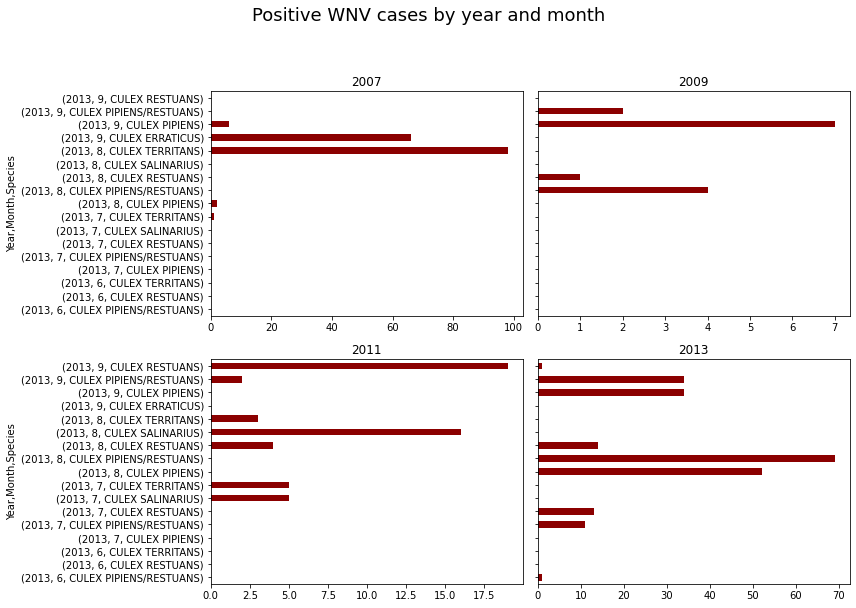

In [61]:
#Positive WNV cases by year and month
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Positive WNV cases by year and month', fontsize=18, y=1.05)
for i, y in enumerate(train_year):
    train[train['Year']==y].groupby(['Year','Month','Species']).WnvPresent.sum().plot(kind='barh', ax=ax[i],color='darkred')
    ax[i].set_title(y)
plt.tight_layout()

In [62]:
train_weather = pd.merge(train,weather,on=['Date'], how = 'inner')
train_weather.head()

,Date,Species,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year_x,Month_x,...,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,Year_y,Month_y,Week,Day_y,precip_7D_avg
0,2007-05-29,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,2007,5,...,49.333333,58,65,BR HZ,0.0,2007,5,22,29,0.153143
1,2007-05-29,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,2007,5,...,51.333333,59,66,BR HZ,0.0,2007,5,22,29,0.064429
2,2007-05-29,CULEX RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,2007,5,...,49.333333,58,65,BR HZ,0.0,2007,5,22,29,0.153143
3,2007-05-29,CULEX RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,2007,5,...,51.333333,59,66,BR HZ,0.0,2007,5,22,29,0.064429
4,2007-05-29,CULEX RESTUANS,N MANDELL AVE,T007,41.994991,-87.769279,1,0,2007,5,...,49.333333,58,65,BR HZ,0.0,2007,5,22,29,0.153143


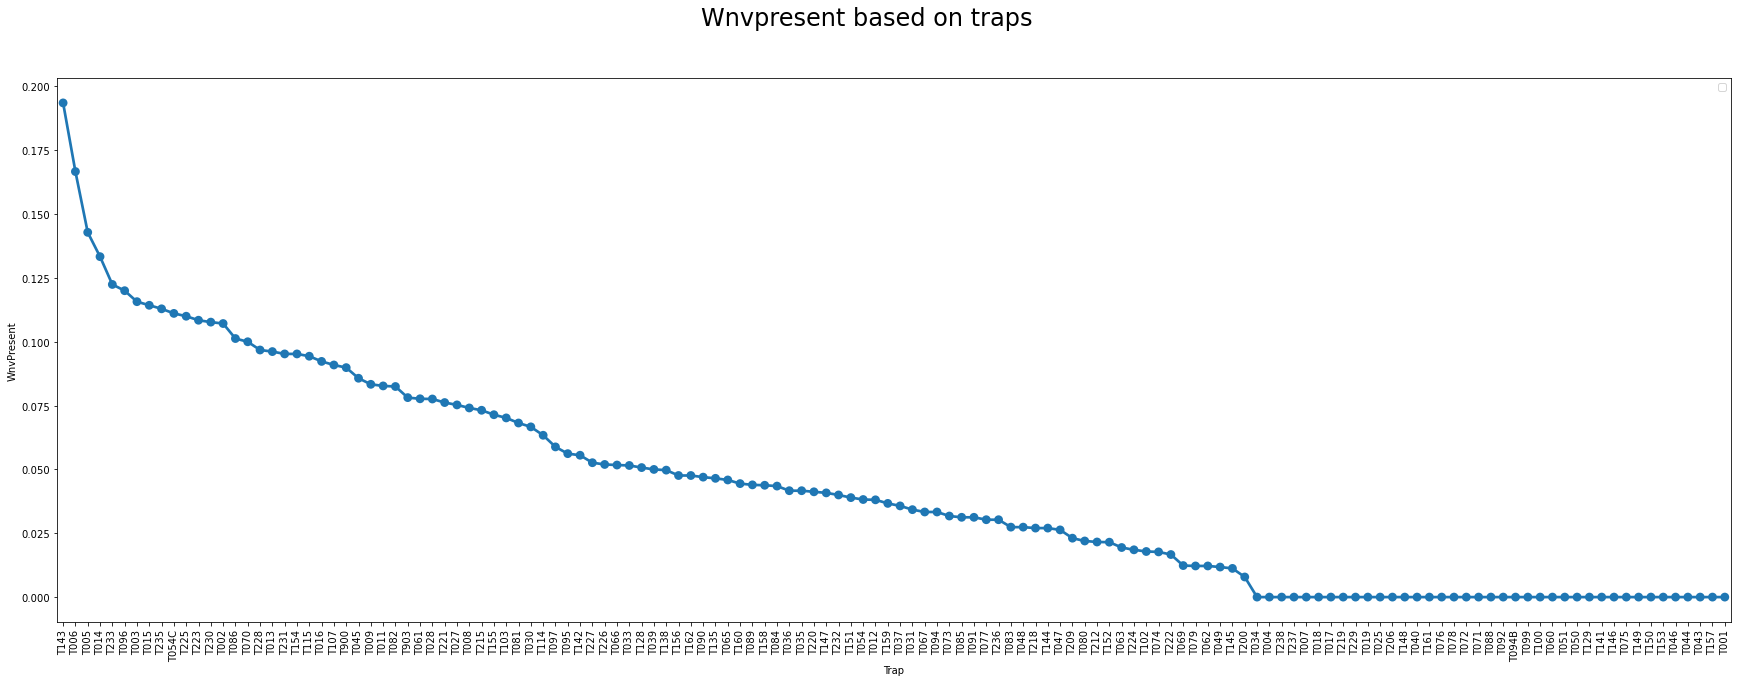

In [63]:
# Identifying trap that are the most likely catch mosquitoes with virus
tmp = pd.crosstab(train['Trap'],train['WnvPresent'],normalize='index')
tmp.reset_index(drop=True)
tmp.columns = ['WnvAbsent','WnvPresent']
fig,ax = plt.subplots(1,1, figsize = (30, 10))

ax.tick_params(axis='x',rotation=90)

sns.pointplot(x = tmp.index,
              y = 'WnvPresent', 
              data = tmp ,
              ax=ax, 
              order = tmp.sort_values(by = 'WnvPresent', ascending = False).index,
              label = 'presences of wnvpresent')

# Combine handles & labels from 2 subplots
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles, labels)
plt.suptitle('Wnvpresent based on traps', fontsize=24)
plt.show()

In [64]:
tmp['WnvPresent'].sort_values(ascending=False).head(20)

Trap
T143     0.193548
T006     0.166667
T005     0.142857
T014     0.133333
T233     0.122449
T096     0.120000
T003     0.115702
T015     0.114286
T235     0.112903
T054C    0.111111
T225     0.110000
T223     0.108434
T230     0.107692
T002     0.107143
T086     0.101266
T070     0.100000
T228     0.096774
T013     0.096154
T231     0.095238
T154     0.095238
Name: WnvPresent, dtype: float64

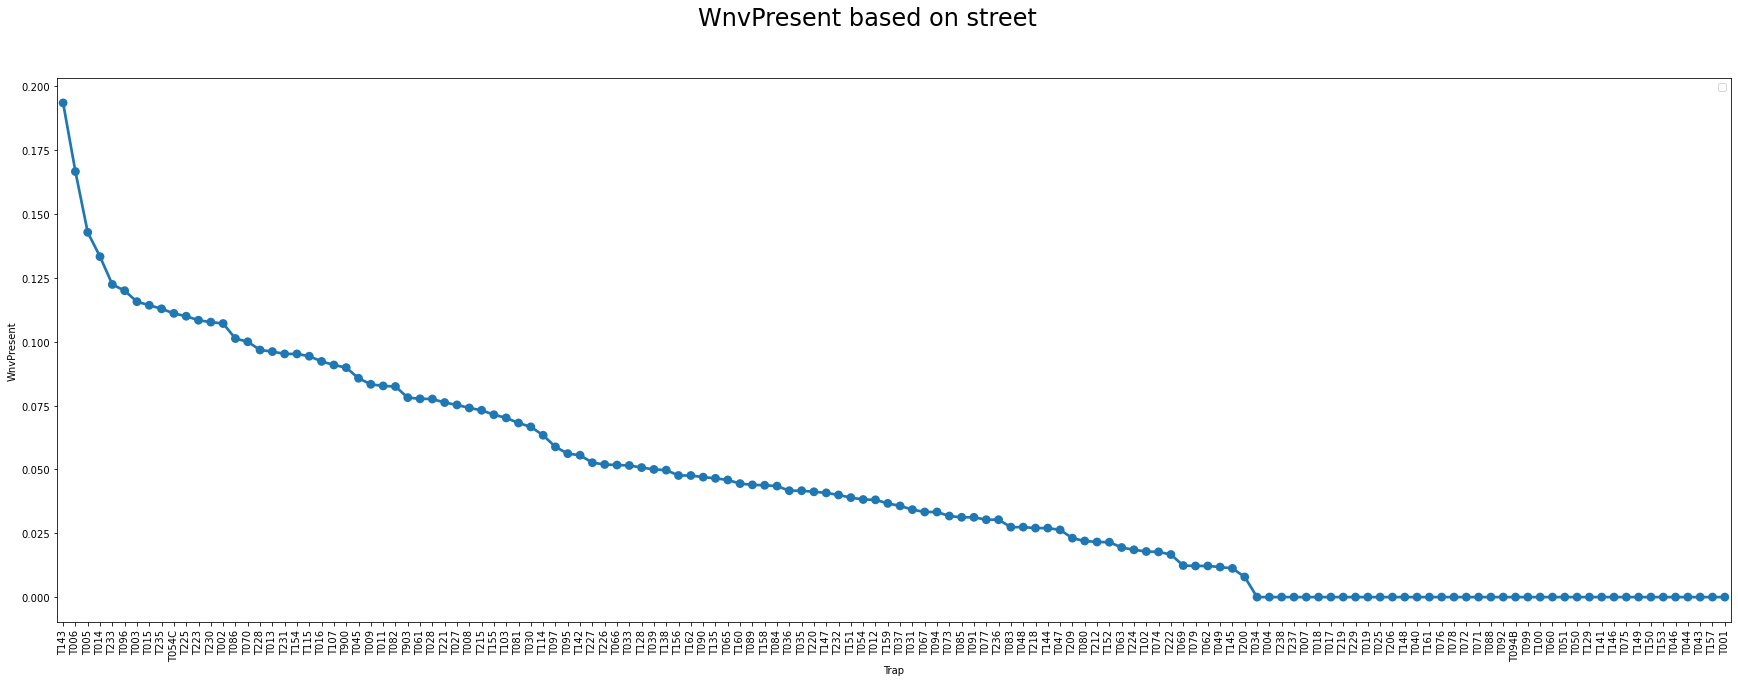

In [65]:
# Identifying street that are the most likely carriers of Virus.
tmp2 = pd.crosstab(train['Street'],train['WnvPresent'],normalize='index')
tmp2.reset_index(drop=True)
tmp2.columns = ['WnvAbsent','WnvPresent']
fig,ax = plt.subplots(1,1, figsize = (30, 10))

ax.tick_params(axis='x',rotation=90)

sns.pointplot(x = tmp.index,
              y = 'WnvPresent', 
              data = tmp ,
              ax=ax, 
              order = tmp.sort_values(by = 'WnvPresent', ascending = False).index,
              label = 'presences of wnvpresent')

# Combine handles & labels from 2 subplots
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles, labels)
plt.suptitle('WnvPresent based on street', fontsize=24)
plt.show()

In [66]:
tmp2['WnvPresent'].sort_values(ascending=False).head(20)

Street
 N AVONDALE AVE       0.166667
 W ROSCOE ST          0.142857
 W STRONG ST          0.133333
 N HARLEM AVE         0.122449
 N OAK PARK AVE       0.120603
 W 89TH ST            0.120000
 N MILWAUKEE AVE      0.115702
 W FOSTER AVE         0.114286
 W 65TH ST            0.112903
 S KOSTNER AVE        0.110000
 N MONT CLARE AVE     0.108434
 N LARAMIE AVE        0.107692
 W 113TH ST           0.101266
 S NORDICA            0.100000
 W HIGGINS AVE        0.096774
 N SPRINGFIELD AVE    0.096774
 W FULLERTON AVE      0.096154
 N LAWLER AVE         0.095238
 N RIDGE AVE          0.095238
 S DOTY AVE           0.094340
Name: WnvPresent, dtype: float64

In [67]:
#columns used for EDA, extra info, no longer needed
train.drop(columns=['Year', 'Month', 'Day', 'Trap', 'Street'], inplace=True)

In [68]:
train_cleaned=train
train_cleaned.to_csv("../datasets/train_cleaned.csv", index=False)

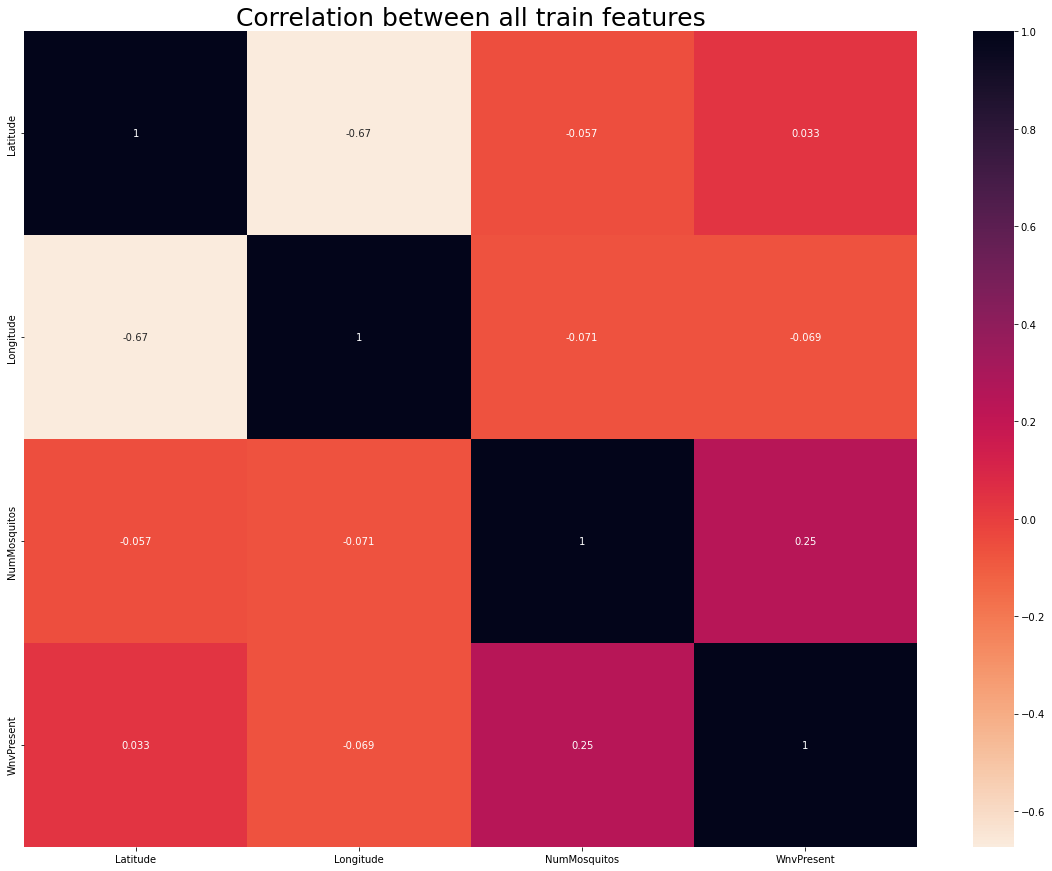

In [69]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
#sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(train_cleaned.corr(), annot=True, cmap="rocket_r" ,ax = ax)
plt.title("Correlation between all train features", fontsize=25);
plt.show()

## 2.5 Feature Engineering

In [70]:
# Create temp range from tmax and tmin values
weather['Trange'] = weather['Tmax'] - weather['Tmin']

In [71]:
# Create relative humidity from tavg and dewpoint values
def relative_humidity(tavg,dewpoint):
    # Formula to convert temperature from Farenheit to celsius : Tc=5.0/9.0x(Tf-32.0) 
    # Formula to convert dewpoint from Farenheit to celsius : Tdc=5.0/9.0x(Tdf-32.0)
    tavg_celcius = (5.0/9.0)*(tavg-32.0)
    dewpoint_celcius = (5.0/9.0)*(dewpoint-32.0)
    
    # and 6.11x10.0x(7.5xTdc/(237.7+Tdc)) for saturated vapor pressure.
    saturation_vapour_pressure = 6.11*10.0*(7.5*tavg_celcius/(237.7+tavg_celcius))
     # 6.11x10.0x(7.5xTc/(237.7+Tc)) for actual vapor pressure 
    actual_pressure = 6.11*10.0*(7.5*dewpoint_celcius/(237.7+dewpoint_celcius))
    
    # relative humidity = (actual_pressure/saturation_vapour_pressure)*100)
    return round(((actual_pressure/saturation_vapour_pressure)*100))

In [72]:
weather['relative_humidity']=relative_humidity(weather['Tavg'],weather['DewPoint'])

In [73]:
weather.drop(columns=['Tmax', 'Tmin', 'DewPoint', 'Year', 'Month', 'Day', 'WetBulb', 'CodeSum', 'PrecipTotal'], inplace=True)

In [74]:
weather_cleaned=weather
weather_cleaned.to_csv("../datasets/weather_cleaned.csv", index=False)

## 2.6 Combine train and weather data

In [75]:
weather.head()

,Station,Date,Tavg,Week,precip_7D_avg,Trange,relative_humidity
12,1,2007-05-07,43.333333,19,0.000429,36,80.0
14,1,2007-05-08,45.333333,19,0.000429,28,190.0
15,2,2007-05-08,46.666667,19,0.000286,20,167.0
16,1,2007-05-09,46.000000,19,0.019000,16,187.0
17,2,2007-05-09,46.666667,19,0.003143,13,185.0


In [76]:
train.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0


In [77]:
#merging cleaned train and cleaned weather by dates
train_weather = pd.merge(train,weather,on=['Date'], how = 'inner')
train_weather.to_csv("../datasets/train_weather.csv", index=False)
train_weather.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Station,Tavg,Week,precip_7D_avg,Trange,relative_humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,1,49.333333,22,0.153143,28,147.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,2,51.333333,22,0.064429,23,137.0
2,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,1,49.333333,22,0.153143,28,147.0
3,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,2,51.333333,22,0.064429,23,137.0
4,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,1,49.333333,22,0.153143,28,147.0


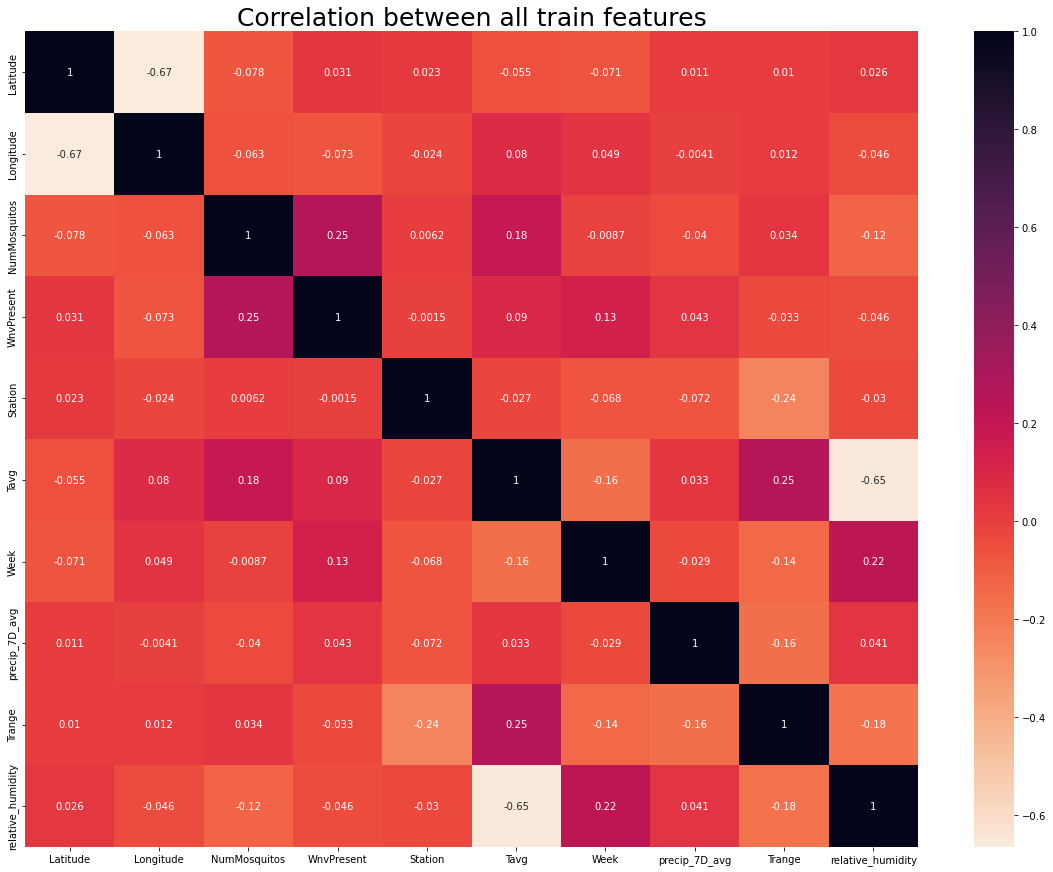

In [78]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
#sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(train_weather.corr(), annot=True, cmap="rocket_r" ,ax = ax)
plt.title("Correlation between all train features", fontsize=25);
plt.show()

--- 
# Part 3
Modeling
---

## 3.1 Modeling preprocessing

In [79]:
train_weather.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Station,Tavg,Week,precip_7D_avg,Trange,relative_humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,1,49.333333,22,0.153143,28,147.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,2,51.333333,22,0.064429,23,137.0
2,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,1,49.333333,22,0.153143,28,147.0
3,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,2,51.333333,22,0.064429,23,137.0
4,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,1,49.333333,22,0.153143,28,147.0


In [80]:
# One hot encoding species
train_weather2 = pd.get_dummies(train_weather,columns=['Species'])

In [81]:
explore (train_weather2)

(8951, 17)

        Date   Latitude  Longitude  NumMosquitos  WnvPresent  Station  \
0 2007-05-29  41.954690 -87.800991             1           0        1   
1 2007-05-29  41.954690 -87.800991             1           0        2   
2 2007-05-29  41.954690 -87.800991             1           0        1   
3 2007-05-29  41.954690 -87.800991             1           0        2   
4 2007-05-29  41.994991 -87.769279             1           0        1   

        Tavg  Week  precip_7D_avg  Trange  relative_humidity  \
0  49.333333    22       0.153143      28              147.0   
1  51.333333    22       0.064429      23              137.0   
2  49.333333    22       0.153143      28              147.0   
3  51.333333    22       0.064429      23              137.0   
4  49.333333    22       0.153143      28              147.0   

   Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                    

In [82]:
#otherwise it wouldnt run later due to types, set it as index
train_weather2.set_index('Date',inplace=True)

## 3.2 Train model

In [83]:
train_weather3 = train_weather2.drop('WnvPresent', axis =1)

In [84]:
# Set X and y
X = train_weather3
y = train_weather2['WnvPresent']

In [85]:
#baseline accuracy before smote
y.value_counts(normalize=True)

#after smote, baseline accuracy would be 0.5

0    0.937325
1    0.062675
Name: WnvPresent, dtype: float64

In [86]:
X.columns = X.columns.sort_values()

In [87]:
#test size set at 20%
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y,test_size=0.2)
X_train.shape, X_test.shape

((7160, 15), (1791, 15))

In [88]:
#standard scaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [89]:
#constructing 4 pipeline
# pipe line 1, smote with Randomforestclassifier
# SMOTE synthesises new minority instances between existing minority instances
# SMOTE applies KNN approach where it selects K nearest neighbors, joins them and creates the synthetic samples in the space.
# RandomForestClassifier fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
pipe_1 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=15)), 
                   ('RF', RandomForestClassifier(random_state=42))])
# pipe line 2, smote with XGBClassifier
#XGBClassifier is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library
pipe_2 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=10)), 
                   ('xgb', XGBClassifier(n_estimators=200,learning_rate=0.3))])
# pipe line 3, smote with AdaBoostClassifier
# AdaBoostClassifier begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases
pipe_3 = Pipeline([('sampling', SMOTE(random_state=42)),
                   ('ada', AdaBoostClassifier())])
#logistic regression
pipe_4 = Pipeline([('sampling', SMOTE(random_state=42)),
                   ('logr', LogisticRegression())])

#function to run pipeline with GridSearchCV
def run_model(pipe, pipe_params):
    
    global X_train_ss,X_test_ss,y_train,y_test
    
    #include gridsearch
    gs = GridSearchCV(pipe,param_grid = pipe_params,scoring = 'roc_auc', cv=5, verbose = 1, n_jobs = -1)
    gs.fit(X_train_ss,y_train)
    print(gs.best_params_)
    preds = gs.predict(X_test_ss)
    print("MCC score: ", matthews_corrcoef(y_test,preds))
    print("Accuracy score: ", gs.score(X_test_ss,y_test))
    plot_confusion_matrix(gs,X_test_ss,y_test)
    plot_roc_curve(gs,X_test_ss,y_test)

#function to run pipeline with RandomizedSearchCV
#RandomizedSearchCV the model selects the combinations randomly
def run_model2(pipe, pipe_params):
    
    global X_train_ss,X_test_ss,y_train,y_test
    
    #include gridsearch
    gs = RandomizedSearchCV(pipe, param_distributions=pipe_params, scoring = 'roc_auc', random_state=42, cv=5, verbose = 1, n_jobs = -1)
    gs.fit(X_train_ss,y_train)
    print(gs.best_params_)
    preds = gs.predict(X_test_ss)
    print("MCC score: ", matthews_corrcoef(y_test,preds))
    print("Accuracy score: ", gs.score(X_test_ss,y_test))
    plot_confusion_matrix(gs,X_test_ss,y_test)
    plot_roc_curve(gs,X_test_ss,y_test)
    
    
pipe_params_1 = {'sampling__k_neighbors': [10, 15,20], 
                 'RF__n_estimators': [10, 20, 30], 
                 'RF__max_leaf_nodes': [3, 4, 5],
                 'RF__max_depth': [3, 4, 5]}

pipe_params_2 = {'sampling__k_neighbors': [10, 15],
                 'xgb__n_estimators': [50, 100,], 
                 'xgb__learning_rate': [0.03, 0.05,],
                 'xgb__max_depth':[4, 5],
                 'xgb__n_estimators': [50, 60],
                 'xgb__subsample':[0.8, 1],
                 'xgb__verbosity': [0,2]}

pipe_params_3 = {'sampling__k_neighbors': [10,15,20], 
                 'ada__n_estimators': [50, 100, 150],
                 'ada__learning_rate': [0.9, 1]}

pipe_params_4 = {'sampling__k_neighbors': [10,15,20], 
                 'logr__penalty': ['l1', 'l2'],
                 'logr__C':np.logspace(-4,4),
                 'logr__class_weight': [None, 'balanced']}


Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'RF__max_depth': 3, 'RF__max_leaf_nodes': 5, 'RF__n_estimators': 30, 'sampling__k_neighbors': 10}
MCC score:  0.3359054122667196
Accuracy score:  0.8715407768229387


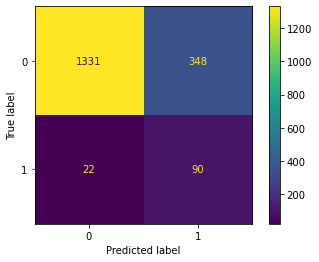

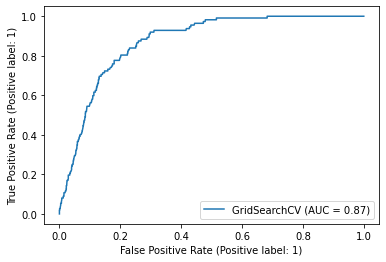

In [90]:
run_model(pipe_1, pipe_params_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'sampling__k_neighbors': 15, 'RF__n_estimators': 20, 'RF__max_leaf_nodes': 5, 'RF__max_depth': 3}
MCC score:  0.3185329430817036
Accuracy score:  0.8661565132306646


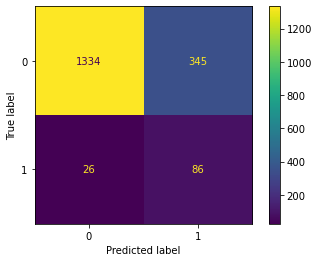

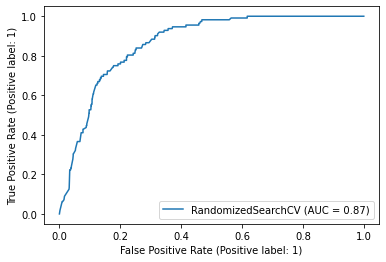

In [91]:
run_model2(pipe_1, pipe_params_1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'sampling__k_neighbors': 10, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 60, 'xgb__subsample': 1, 'xgb__verbosity': 0}
MCC score:  0.3528011834130886
Accuracy score:  0.894157342806092


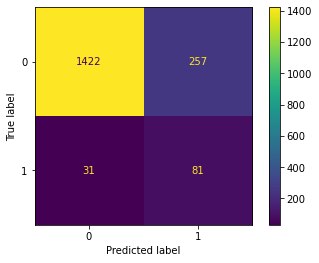

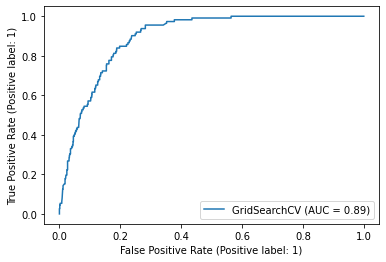

In [92]:
run_model(pipe_2, pipe_params_2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:16:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:16:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:16:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:16:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:16:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:16:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tr

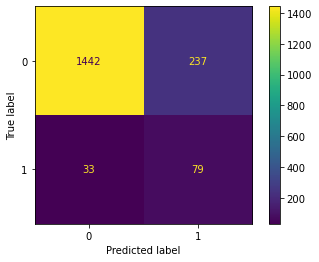

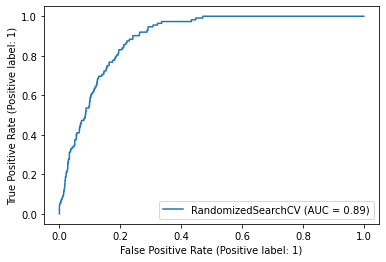

In [93]:
run_model2(pipe_2, pipe_params_2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'ada__learning_rate': 0.9, 'ada__n_estimators': 150, 'sampling__k_neighbors': 10}
MCC score:  0.33494824212511515
Accuracy score:  0.8781454734961286


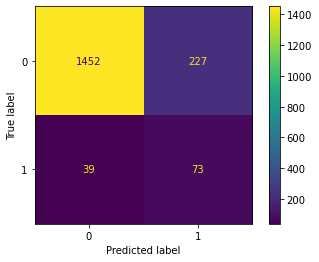

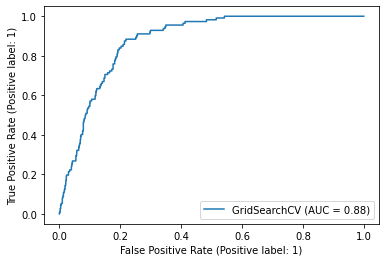

In [94]:
run_model(pipe_3, pipe_params_3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'sampling__k_neighbors': 10, 'ada__n_estimators': 150, 'ada__learning_rate': 1}
MCC score:  0.3408618319811266
Accuracy score:  0.8823225984854931


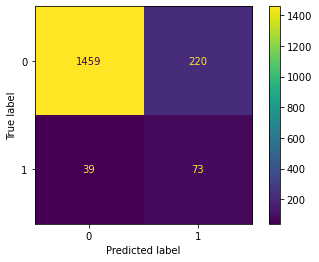

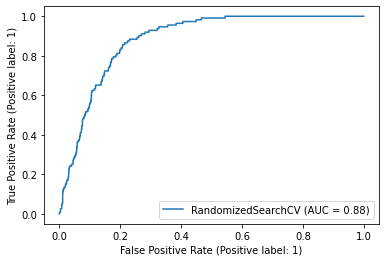

In [95]:
run_model2(pipe_3, pipe_params_3)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
{'logr__C': 0.013257113655901081, 'logr__class_weight': None, 'logr__penalty': 'l2', 'sampling__k_neighbors': 20}
MCC score:  0.3276230203324246
Accuracy score:  0.8685947204968945


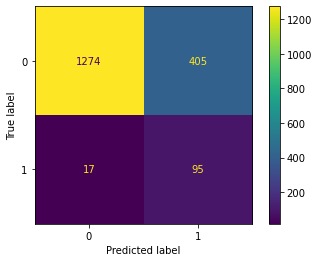

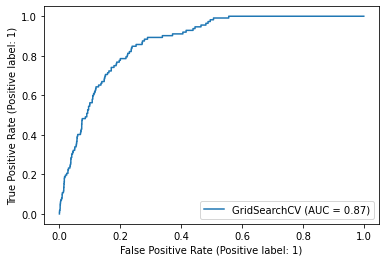

In [96]:
run_model(pipe_4, pipe_params_4)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'sampling__k_neighbors': 20, 'logr__penalty': 'l2', 'logr__class_weight': 'balanced', 'logr__C': 35.564803062231285}
MCC score:  0.3178610816113345
Accuracy score:  0.8671908236195013


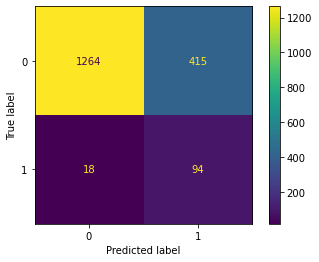

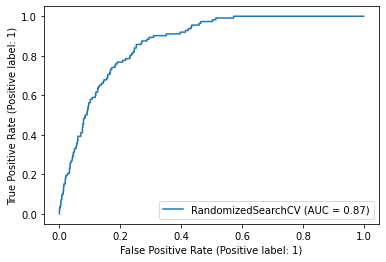

In [97]:
run_model2(pipe_4, pipe_params_4)

## 3.3 Test data manipulation

In [98]:
weather.head()

,Station,Date,Tavg,Week,precip_7D_avg,Trange,relative_humidity
12,1,2007-05-07,43.333333,19,0.000429,36,80.0
14,1,2007-05-08,45.333333,19,0.000429,28,190.0
15,2,2007-05-08,46.666667,19,0.000286,20,167.0
16,1,2007-05-09,46.000000,19,0.019000,16,187.0
17,2,2007-05-09,46.666667,19,0.003143,13,185.0


In [99]:
test.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Trap'], inplace=True)
#convert date format
test['Date'] = pd.to_datetime(test['Date'])
#test = pd.merge(test,weather,on = ['Date'])

explore(test)

(116293, 5)

   Id       Date                 Species  Latitude  Longitude
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  41.95469 -87.800991
1   2 2008-06-11          CULEX RESTUANS  41.95469 -87.800991
2   3 2008-06-11           CULEX PIPIENS  41.95469 -87.800991
3   4 2008-06-11        CULEX SALINARIUS  41.95469 -87.800991
4   5 2008-06-11         CULEX TERRITANS  41.95469 -87.800991

Id                    int64
Date         datetime64[ns]
Species              object
Latitude            float64
Longitude           float64
dtype: object

Id           0
Date         0
Species      0
Latitude     0
Longitude    0
dtype: int64

                  Id       Latitude      Longitude
count  116293.000000  116293.000000  116293.000000
mean    58147.000000      41.849389     -87.693658
std     33571.041765       0.106593       0.080699
min         1.000000      41.644612     -87.930995
25%     29074.000000      41.753411     -87.750938
50%     58147.000000      41.862292     -87.694991
75%     87220

In [100]:
# One hot encoding species
test2 = pd.get_dummies(test,columns=['Species'])

In [101]:
testmod = test2.columns.tolist()
testmod.remove('Id')

In [102]:
#seeing difference between train and test data
set_a = set(testmod)
set_b = set(train_weather2.columns)

#in test but not in train set
print(set_a.difference(set_b))
print(' ')
#in train set but not in test set
print(set_b.difference(set_a))

#put differences of column features of, (in test but not in train) into a variable 'list_a'
list_a = list(set_a.difference(set_b))
list_b = list(set_b.difference(set_a))

{'Species_UNSPECIFIED CULEX', 'Species_CULEX ERRATICUS', 'Date'}
 
{'precip_7D_avg', 'WnvPresent', 'relative_humidity', 'Station', 'NumMosquitos', 'Tavg', 'Week', 'Trange'}


In [103]:
#test drop columns that are not in train set
test2.drop(columns = list_a, inplace = True, errors = 'ignore')

#fill nan to 0 in test 
test2.fillna(0, inplace = True)

In [104]:
#fill 0 values for columns not present in test data
test2['NumMosquitos'] = 0
test2['precip_7D_avg'] = 0
test2['Week'] = 0
test2['relative_humidity'] = 0
test2['Trange'] = 0
test2['Station'] = 0
test2['Tavg'] = 0

In [105]:
test2.shape

(116293, 16)

In [106]:
X = train_weather3
y = train_weather2['WnvPresent']
X_test = test2.drop('Id', axis =1)

## 3.4 Model RandomForest

In [107]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=15)), 
                    ('RF', RandomForestClassifier(n_estimators=20, max_leaf_nodes = 5))])

best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)[:,1]

In [108]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']

In [109]:
testing_submission.to_csv('../datasets/model1submission.csv', index=False)

## 3.5 Model ADAboost

In [110]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=10)),
                   ('ada', AdaBoostClassifier(learning_rate = 0.9, n_estimators = 150))])


best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)[:,1]

In [111]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model2submission.csv', index=False)

## 3.6 Model XGBoost

In [112]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=10)), 
                    ('xgb', XGBClassifier(learning_rate  = 0.05, max_depth = 5, 
                                          n_estimators = 60, subsample = 1,
                                          verbosity = 0))])




best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)[:,1]

In [113]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model3submission.csv', index=False)

## 3.7 Model Logistic Regression

In [114]:
# create predictions and submission file
best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=20)), 
                    ('logr', LogisticRegression(penalty  = 'l2', class_weight = 'balanced', 
                                          C= 35.564803062231285))])

best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)

In [115]:
test2['WnvPresent'] = predictions
testing_submission = test2[['Id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']
testing_submission.to_csv('../datasets/model4submission.csv', index=False)

--- 
# Part 4
Conclusion & Recommendations
---

It was observed that about the virus is present in about 5.19% of the number of mosquitoes caught
The mosquito species containing the virus are from the genus 'Culex' and species 'Restuans' and 'Pipiens', with crossbreed Culex Restauns/Pipiens
These species are considered pests and they are likely to have very close similarities with each other.
([*source*](https://www.ecdc.europa.eu/en/all-topics-z/disease-vectors/facts/mosquito-factsheets/culex-pipiens-factsheet-experts))
([*source*](https://vectorbio.rutgers.edu/outreach/species/rest.htm))
The virus are not found in the mosquitoes species 'Erraticus', 'Salinarus', 'Tarsalis' and 'Territans' which are caught, this 
means that it is unlikely that they would carry the virus however we would not rule out that possibility.  
  
It was observed that across the years, 2007 to 2013 there are similar number of mosquitoes caught with the virus with 
the most cases recorded at July and eventually subside (decreasing trend) by November. This is due to the climate/season
and temperature changes. Refering to the linegraph, temperature and rainfall peaks at July and generally decreases towards November in similar fashion/trend. This is reflected by the number of positive cases and the number of mosquitoes caught around July to October.  

There is a slight upward trend in the presence of west nile virus. Hence We suggest that the local authorities to focus efforts on their preventive measures where areas are predicted to have at least 60% probability of having West Nile Virus.
  
**1) The study of weather patterns on mosquito behaviour**
As observed in our EDA section, the relationship between the weather features is still unclear. On top of this, it can be observed that the presence of WNV peaks around the approximately same few months, regardless of weather patterns. This could also indicate that there could be other influencing factors, for example dense human population in certain areas.
  
**2) Understanding mosquitos WNV transmission**
As WNV is only transmitted by either Culex Restauns, Culex Pipiens and their crossbreed, by understanding this specific species behavoir and areas that breeds them would allow us to investigate where they get the virus from and perhaps curb the spread by curbing the root problem.
  
**3) More training data**
Our model was trained on *10506* observations, but we were making predictions on *116293* observations. Our predictions may improve tremendously, if we can acquire more data for our model training.

**4) Targeted mosquito spraying and data collection efforts**  
To maximise city resources, all mosquito-borne disease statistics should be handled by a single dedicated department in the city council. That way appropriate steps can be taken quickly, eliminating administrative lag between testing and reporting. Regular mosquito pre-spraying efforts should also be undertaken in summer months at mosquito hotspots, where identified to have a higher probablity of the presence of the WNV virus.  
Mosquitoes hotspots can be the places where the traps have captured most mosquitoes or streets found with virus present.


In [116]:
print(f'Number of WnvPresent Cases in Train data: {y.value_counts()[1]}')

Number of WnvPresent Cases in Train data: 561


**Model 1** obtained a score (kaggle), smote, randomforest, gridsearchcv of 0.526. 
  
**Model 2** obtained a score (kaggle), smote, adavoost, gridsearchcv of 0.527.
  
**Model 3** obtained a score (kaggle), smote, xgboost, gridsearchcv  of 0.427.
  
**Model 4** obtained a score (kaggle), smote, logistic regression, gridsearchcv of 0.623.  
  
  
**5) Spray cost data**  
Insights on cost can be made if we have the data for cost of spraying. 